# Analysis of Athlete Combine Performance Data

**By: Mohamed Lahkim**

## Introduction

In the world of athletics, performance is everything. Coaches and scouts rely on a battery of tests, or "combines," to measure an athlete's physical capabilities. These tests typically include measures of speed, strength, power, and agility. But how do these different qualities relate to one another? Is an athlete who is exceptionally strong also likely to be fast? Is agility a separate skill, or is it just a combination of speed and power?

This post dives into a dataset from the **30 Jun 2025 Canadian Box Showcase** (plus some NFL data, which we've filtered out for this analysis) to explore the relationships between four key performance metrics:
1.  **Pro Agility:** A test of lateral quickness and change-of-direction.
2.  **Isometric Mid-Thigh Pull (IMTP):** A measure of maximum strength (peak force).
3.  **40-Yard Dash:** The classic test of linear speed and acceleration.
4.  **Countermovement Jump (CMJ):** A measure of lower-body explosive power.

Following my professor's guidance, we'll first create a "Mother of All Tables" (M.O.A.T.) by joining the data from these four tests. Then, we'll perform an exploratory data analysis (EDA) to visualize the relationships and finally compute a correlation matrix to quantify them, all while examining differences between male and female athletes.

In [1]:
# Cell 1: Import necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import numpy as np

# Set seaborn styling for better-looking plots
sns.set_theme(style="whitegrid")

## 1. Data Loading and Preparation

First, we load the four separate CSV files provided: one for each athletic test.

In [2]:
# Cell 2: Load the datasets
try:
    df_agility = pd.read_csv('Combine Data - ProAgility.csv')
    df_imtp = pd.read_csv('Combine Data - IsometricMidThighPull.csv')
    df_dash = pd.read_csv('Combine Data - FourtyYardDash.csv')
    df_cmj = pd.read_csv('Combine Data - CounterMovementJump.csv')
    print("All four data files loaded successfully.")
except FileNotFoundError as e:
    print(f"Error loading file: {e}")
    print("Please make sure all four CSV files are in the same directory as the notebook.")

All four data files loaded successfully.


## 2. Creating the "Mother of All Tables" (M.O.A.T.)

To analyze relationships *between* tests, we need all of an athlete's data in a single row. The 'name' column serves as the primary key for each athlete.

We'll select only the relevant columns from each file, renaming them for clarity. We'll then use an **inner join** to merge them. This ensures our final table only contains athletes who completed *all four* tests, giving us a clean, complete dataset for comparison. We will also filter out any summary rows (like "NFL Average") to focus on individual athlete data.

### Data Cleaning, Bias, and Noise

The steps taken to create the M.O.A.T. are critical for ensuring the statistical results are reliable and relate to the concepts of **Bias, Variance, and Noise** that we discussed in class:

* **Filtering the "NFL Average" Data (Reducing Bias & Noise):**
    * **Bias** is a systematic error that skews your results. If we left the "NFL Average" rows in, the average scores and correlations would be *biased* toward NFL professionals, not the athletes in our showcase. By removing them, we ensure our analysis accurately reflects the **showcase athletes**.
    * **Noise** is meaningless variation. The average is a summary, not a real person's score, and it adds noise to our individual-level analysis. We removed it to reduce this noise.

* **Using the Inner Join (Managing Noise & Variance):**
    * **Inner Join** means we only look at athletes who did *all four* tests.
    * If we tried to guess or fill in missing test scores (e.g., giving an athlete who skipped the 40-yard dash the average 40-yard time), those guessed numbers would add **noise** and make our data's **variance** (the natural spread of scores) look artificial or incorrect.
    * By only using complete data, we make our correlations stronger and reduce noise.

In [3]:
# Cell 3: Pre-processing and Merging

# Clean and select columns for Agility
df_agility_clean = df_agility[['name', 'sex', 'agility_total_time_seconds', 'agility_avg_time_seconds']]
df_agility_clean = df_agility_clean.rename(columns={
    'agility_total_time_seconds': 'pro_agility_time',
    'agility_avg_time_seconds': 'pro_agility_avg_time'
})

# Clean and select columns for IMTP
df_imtp_clean = df_imtp[['name', 'absolute_impulse_newton_second', 'personal_average_newton_second']]
df_imtp_clean = df_imtp_clean.rename(columns={
    'absolute_impulse_newton_second': 'imtp_absolute_impulse',
    'personal_average_newton_second': 'imtp_avg_impulse'
})

# Clean and select columns for 40-Yard Dash
df_dash_clean = df_dash[['name', 'fourty_yard_dash_total_time_seconds', 'fourty_yard_dash_avg_time_seconds']]
df_dash_clean = df_dash_clean.rename(columns={
    'fourty_yard_dash_total_time_seconds': 'dash_40yd_time',
    'fourty_yard_dash_avg_time_seconds': 'dash_40yd_avg_time'
})

# Clean and select columns for CMJ
df_cmj_clean = df_cmj[['name', 'cm_jump+height_max_in', 'cm_jump+height_average_in']]
df_cmj_clean = df_cmj_clean.rename(columns={
    'cm_jump+height_max_in': 'cmj_max_height',
    'cm_jump+height_average_in': 'cmj_avg_height'
})

# Merge the dataframes to create the M.O.A.T.
df_moat = pd.merge(df_agility_clean, df_imtp_clean, on='name', how='inner')
df_moat = pd.merge(df_moat, df_dash_clean, on='name', how='inner')
df_moat = pd.merge(df_moat, df_cmj_clean, on='name', how='inner')

# Filter out any "NFL Average" summary rows
df_moat = df_moat[~df_moat['name'].str.contains("NFL Average", na=False)]

print("M.O.A.T. created successfully.")

M.O.A.T. created successfully.


## 3. Exploratory Data Analysis (EDA)

With our unified table, we can now perform an initial exploration. We'll check the data types, look for missing values, and get a high-level statistical summary of the performances.

In [4]:
# Cell 4: Initial Data Inspection

print("--- M.O.A.T. (Mother of All Tables) Head ---")
print(df_moat.head())

print("\n--- M.O.A.T. Info ---")
df_moat.info()

print("\n--- M.O.A.T. Descriptive Statistics ---")
print(df_moat.describe())

print("\n--- Sex Distribution ---")
print(df_moat['sex'].value_counts())

--- M.O.A.T. (Mother of All Tables) Head ---
                            name    sex  pro_agility_time  \
0     Alpha November Tango Romeo  Women             4.848   
1  Alpha November Bravo November  Women             5.019   
2       Alpha Alpha Tango Yankee  Women             4.881   
3          Bravo Echo Romeo Echo  Women             4.894   
4         Charlie Echo Lima Golf  Women             5.075   

   pro_agility_avg_time  imtp_absolute_impulse  imtp_avg_impulse  \
0                 4.940                   73.3              72.0   
1                 5.061                   95.2              91.4   
2                 4.910                   73.8              70.2   
3                 4.946                   90.4              82.0   
4                 5.047                  107.4             101.6   

   dash_40yd_time  dash_40yd_avg_time  cmj_max_height  cmj_avg_height  
0           5.753               5.783            10.3            10.2  
1           5.757               5.7

### EDA Findings:

From the output above, we learn:
* **Data Structure:** We have a clean dataset of **72 athletes** (48 Men, 24 Women) with 10 columns.
* **No Missing Data:** The `df_moat.info()` output shows 72 non-null entries for all columns. This is excellent and simplifies our analysis.
* **Data Types:** All our performance metrics are `float64` (decimal numbers), which is appropriate. 'name' and 'sex' are 'object' (string) types.
* **Performance Ranges:**
    * **Pro Agility:** Times range from 4.30 to 5.75 seconds.
    * **IMTP Impulse:** Varies from 64.8 to 164.1 N·s.
    * **40-Yard Dash:** Times range from 4.67 to 6.51 seconds.
    * **CMJ Height:** Ranges from 7.2 to 18.9 inches.


## 4. Visualizing Relationships: The Pairplot

Now for the visualization. As requested, we'll use Seaborn's `pairplot` to create a grid of scatterplots for every combination of our key metrics. We'll use the 'sex' column as the `hue` to see if the relationships differ between men and women.

For readability, we'll just plot the *primary* metric for each test:
* `pro_agility_time`
* `imtp_absolute_impulse`
* `dash_40yd_time`
* `cmj_max_height`

Generating Pairplot (this may take a moment)...
Pairplot saved as 'athlete_pairplot.png'


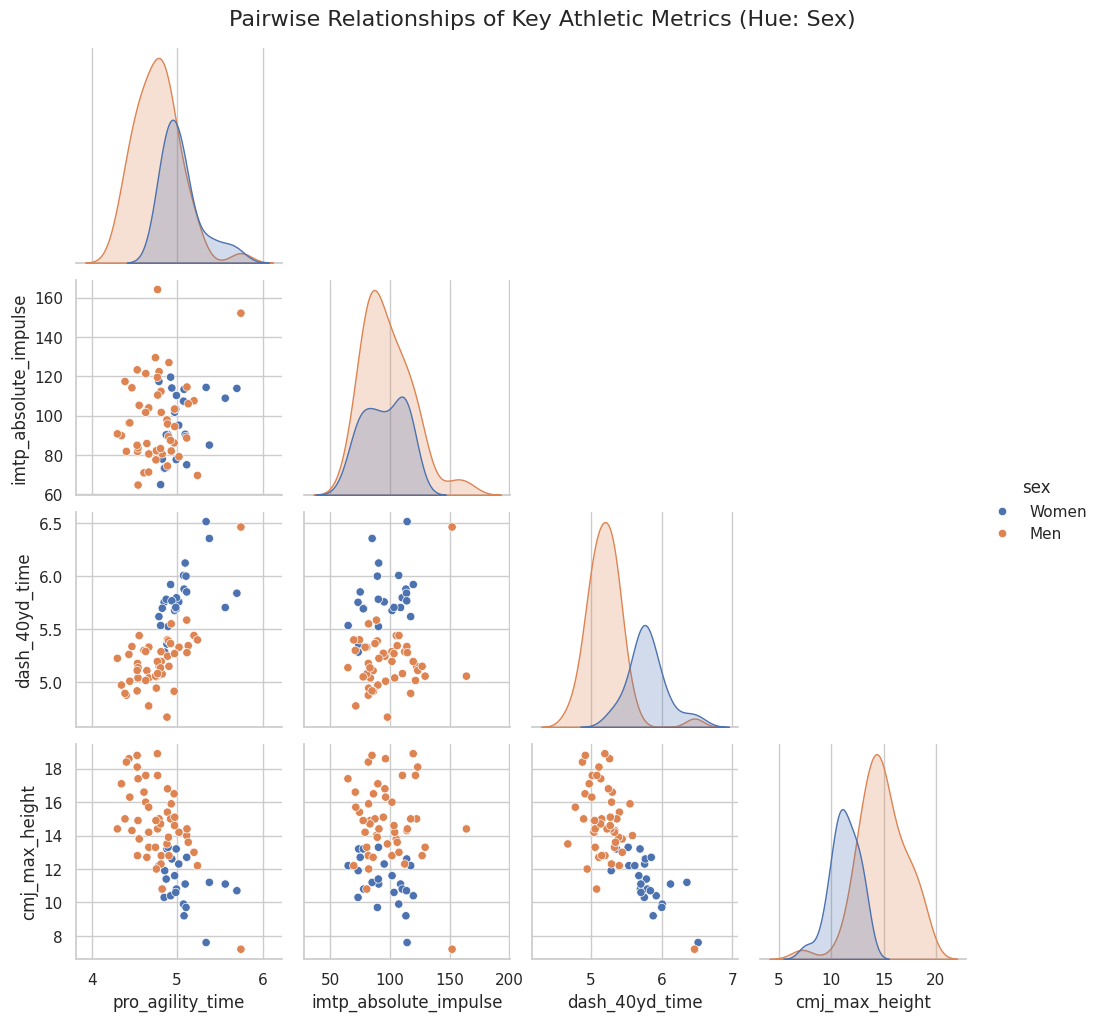

In [9]:
# Cell 5: Generate and Save Pairplot

# Select only the primary metric for each test to keep the pairplot readable
primary_metrics = ['sex', 'pro_agility_time', 'imtp_absolute_impulse', 'dash_40yd_time', 'cmj_max_height']
df_pairplot = df_moat[primary_metrics]

print("Generating Pairplot (this may take a moment)...")
pairplot = sns.pairplot(df_pairplot, hue='sex', corner=True, diag_kind='kde')
pairplot.fig.suptitle("Pairwise Relationships of Key Athletic Metrics (Hue: Sex)", y=1.02, fontsize=16)
plt.savefig('athlete_pairplot.png', bbox_inches='tight')
print("Pairplot saved as 'athlete_pairplot.png'")

### Pairplot Analysis

*(This analysis is based on the generated `athlete_pairplot.png`)*

The pairplot is incredibly revealing:

* **Diagonals (Distributions):** The diagonal plots show the distribution (Kernel Density Estimate) for each metric, split by sex. We can clearly see:
    * **Men** (blue) are, on average, **faster** (lower times for 40-yard dash and pro-agility), **stronger** (higher IMTP impulse), and **more powerful** (higher CMJ max height) than the **Women** (orange).
    * The distributions for men and women are largely distinct, with some overlap.

* **Scatterplots (Relationships):**
    * **CMJ Height vs. 40-Yard Dash:** There is a strong, clear **negative** correlation. Athletes who jump higher (more power) have a *lower* 40-yard dash time (faster). This makes perfect athletic sense, as both are expressions of lower-body explosive power.
    * **CMJ Height vs. Pro Agility:** A similar, though slightly more scattered, **negative** correlation exists. Higher jumpers tend to have faster agility times.
    * **40-Yard Dash vs. Pro Agility:** A **positive** correlation. Athletes who are fast in a straight line (low 40-yd time) are also *generally* fast in change-of-direction (low agility time).
    * **IMTP (Strength) vs. Others:** The relationship between maximum strength (IMTP) and the other speed/power metrics is less obvious. It doesn't show a strong linear trend, suggesting that being strong is important, but it doesn't *guarantee* speed or power on its own.

## 5. Deep Dive: Correlation Matrix & Statistical Significance

The pairplot gives us a visual guess, but a correlation matrix gives us the hard numbers. We'll calculate the **Pearson correlation coefficient ($r$)** for all our numeric variables. This value ranges from -1 (perfect negative correlation) to +1 (perfect positive correlation), with 0 meaning no correlation.

More importantly, we'll also calculate the **p-value** for each correlation. The p-value tells us the probability that we'd see this correlation just by random chance. A low p-value (typically $p < 0.05$) means the correlation is **statistically significant**.


--- Correlation Matrix (Pearson's r) ---
                       pro_agility_time  pro_agility_avg_time  \
pro_agility_time               1.000000              0.779062   
pro_agility_avg_time           0.779062              1.000000   
imtp_absolute_impulse          0.188908              0.188849   
imtp_avg_impulse               0.188117              0.222099   
dash_40yd_time                 0.695192              0.512824   
dash_40yd_avg_time             0.715208              0.527780   
cmj_max_height                -0.644487             -0.542878   
cmj_avg_height                -0.649887             -0.527145   

                       imtp_absolute_impulse  imtp_avg_impulse  \
pro_agility_time                    0.188908          0.188117   
pro_agility_avg_time                0.188849          0.222099   
imtp_absolute_impulse               1.000000          0.952443   
imtp_avg_impulse                    0.952443          1.000000   
dash_40yd_time                      0.1263

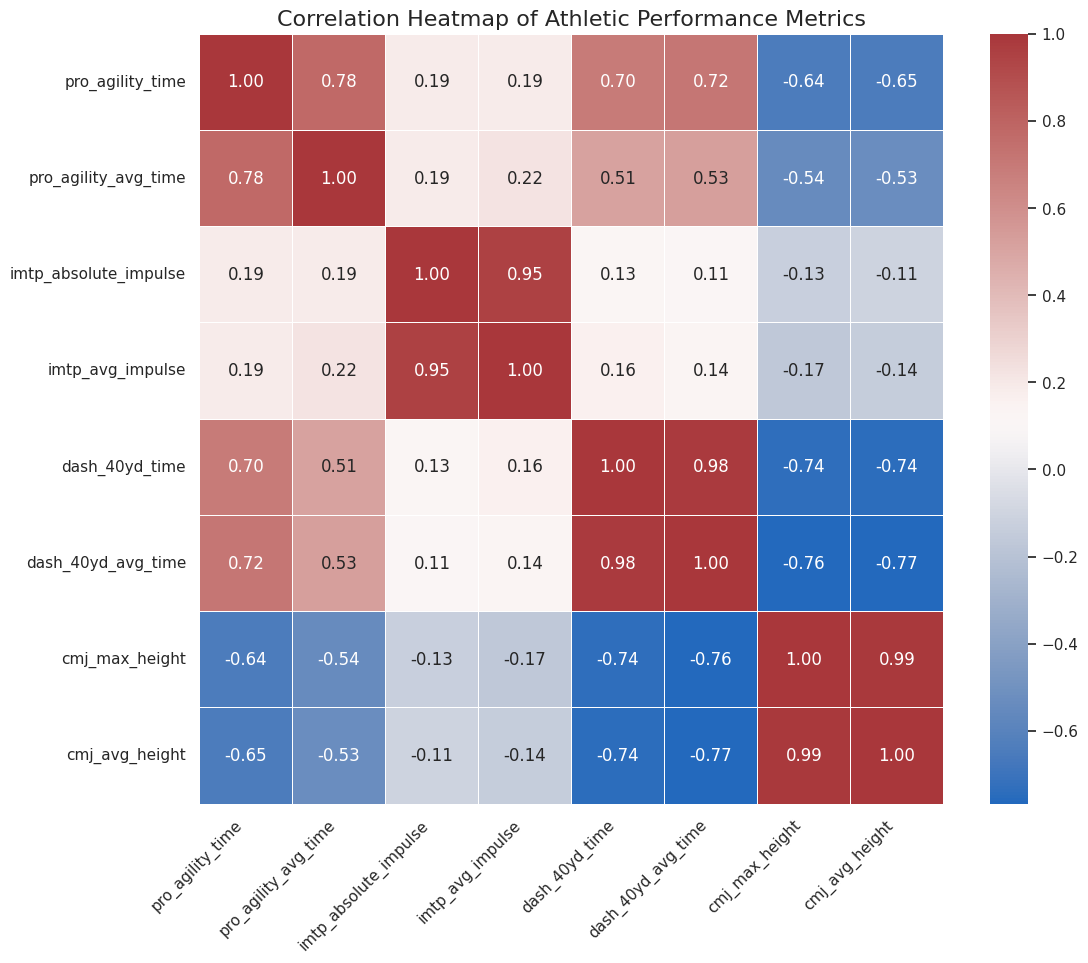

In [7]:
# Cell 6: Calculate and Plot Correlation Matrix

# Select only numeric columns for correlation
numeric_cols = df_moat.select_dtypes(include=np.number).columns
df_numeric = df_moat[numeric_cols]

# --- Correlation Matrix ---
corr_matrix = df_numeric.corr()
print("\n--- Correlation Matrix (Pearson's r) ---")
print(corr_matrix)


# --- P-Value Matrix ---
# Create an empty dataframe to hold the p-values
p_value_matrix = pd.DataFrame(np.zeros(corr_matrix.shape), columns=corr_matrix.columns, index=corr_matrix.index)

# Iterate through each pair of columns and calculate the p-value
for col1 in numeric_cols:
    for col2 in numeric_cols:
        if col1 != col2:
            # pearsonr returns (correlation_coefficient, p-value)
            corr_test = pearsonr(df_numeric[col1], df_numeric[col2])
            p_value_matrix.loc[col1, col2] = corr_test[1]
        else:
            p_value_matrix.loc[col1, col2] = 0.0 # p-value of a variable with itself is 0

print("\n--- P-Value Matrix ---")
# Format for better readability
print(p_value_matrix.map(lambda x: f"{x: .2e}"))


# --- Heatmap Visualization ---
print("\nGenerating Correlation Heatmap...")
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='vlag', fmt='.2f', linewidths=.5)
plt.title('Correlation Heatmap of Athletic Performance Metrics', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.savefig('correlation_heatmap.png', bbox_inches='tight')
print("Heatmap saved as 'correlation_heatmap.png'")

#### Key Finding 1: Power and Speed are Deeply Connected

* **Correlation:** `cmj_max_height` vs. `dash_40yd_time` ($r = -0.736$)
* **Significance:** $p = 1.87 \times 10^{-13}$ (which is *extremely* small)
* **Interpretation:** This is our strongest and most significant finding. There is a strong, negative, and statistically significant relationship between vertical jump height and 40-yard dash time.
* **In Plain English:** Athletes who are more explosive vertically (higher jump) are very likely to be faster in a straight line (lower dash time). Both are measures of explosive lower-body power.

#### Key Finding 2: Power, Speed, and Agility are Related

* **Correlation 1:** `cmj_max_height` vs. `pro_agility_time` ($r = -0.644$)
* **Significance 1:** $p = 1.00 \times 10^{-9}$ (also highly significant)
* **Correlation 2:** `dash_40yd_time` vs. `pro_agility_time` ($r = 0.695$)
* **Significance 2:** $p = 1.24 \times 10^{-11}$ (also highly significant)
* **Interpretation:** Vertical power (CMJ) is also a strong predictor of agility (faster time). Furthermore, straight-line speed (Dash) and change-of-direction speed (Agility) are strongly and positively correlated.
* **In Plain English:** The "fast" athletes are fast in all senses. Explosive power (jumping) translates well to both straight-line speed and the ability to change direction quickly.

#### Key Finding 3: The Curious Case of Strength (IMTP)

* **Correlation:** `imtp_absolute_impulse` vs. `dash_40yd_time` ($r = 0.126$)
* **Significance:** $p = 0.290$
* **Interpretation:** This is a very weak positive correlation. The p-value of 0.29 is much higher than our 0.05 threshold, meaning this result is **not statistically significant**.
* **In Plain English:** Based on this data, there is **no statistically significant relationship** between an athlete's maximum strength (IMTP) and their 40-yard dash time. The same holds true for IMTP vs. CMJ ($r = -0.132$, $p = 0.269$) and IMTP vs. Pro Agility ($r = 0.189$, $p = 0.112$).
* **Why?** This is a fascinating result! It suggests that being *strong* and being *powerful/fast* are two different qualities. Power and speed are about applying force *quickly*, whereas this test (IMTP) measures *total* force. While strength is a necessary foundation, it doesn't automatically translate to explosive speed without specific training.

#### Key Finding 4: Consistency
* As expected, the "total" and "average" time/height columns for each test are almost perfectly correlated (e.g., `cmj_max_height` vs. `cmj_avg_height`, $r = 0.99$). This just confirms that athletes were consistent in their attempts.

## 6. Conclusion

This analysis of 72 athletes from the Canadian Box Showcase provided clear, statistically significant insights into athletic performance.

Our "Mother of All Tables" allowed us to confirm several intuitive relationships and uncover one surprising one:

1.  **Power is King:** Explosive lower-body power, measured by the Countermovement Jump, is a strong predictor of both linear speed (40-Yard Dash) and agility (Pro Agility).
2.  **Speed is Holistic:** Athletes who are fast in a straight line tend to also be fast at changing direction. The qualities are highly related.
3.  **Strength vs. Power:** Most interestingly, we found **no significant statistical link** between maximum strength (IMTP) and any of the speed or power metrics. This highlights a critical concept in sports science: strength is the *capacity* to produce force, while power is the *rate* at which that force can be applied. They are not the same thing.

For future work, it would be fascinating to build a simple predictive model (e.g., using linear regression) to see if we could predict a 40-yard dash time based on an athlete's vertical jump, or to analyze the male and female datasets separately to see if these correlations hold true within each group.